In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

<h1>Figure 6</h1>

<h2>Dataset</h2>

<a href="http://msb.embopress.org/content/7/1/514.long">Lee <i>et al.</i> (2011)</a> reported transcriptomics and proteomics data generated at various time points following onset of an osmotic stress (0.5 M NaCl in YPD). Tables with RNA and Protein changes were downloaded from  the paper's <a href="http://msb.embopress.org/content/msb/7/1/514/DC7/embed/inline-supplementary-material-7.xls?download=true" target=_blank>supplemental material</a> and form the basis for the analysis below.


In [2]:
#read in the data from Lee et al 2011
Lee_all = pd.read_csv('Lee_2011_NaCl.csv')

####calculate a dictionary containing averaged timecourse data for protein/mRNA ratios across the three replicates
ratio_time_courses = {}
#go through each row in Lee_all
for row in range(Lee_all.shape[0]):
    this_row = Lee_all.iloc[row]
    #check whether this row has any meanignful data for protein expression (ie is not all NaN)
    if pd.isnull(this_row[18:]).all():
        continue
    protein_data = []
    mRNA_data = []
    #go through each of the five timepoints
    for timepoint in range(5):
        #generate an array with the averaged time-course data. The protein data begin in column 18 and
        #replicates are offset by five columns. mRNA data begin in column 3 and replicates are again 
        #offset by five columns
        protein_data.append(np.mean(this_row.iloc[[timepoint+18,timepoint + 23,timepoint+28]]))
        mRNA_data.append(np.mean(this_row.iloc[[timepoint+3,timepoint + 8,timepoint+13]]))
    #convert lists to numpy arrays, and also convert from log2 values to fold change
    protein_array = np.exp2(np.array(protein_data))
    mRNA_array = np.exp2(np.array(mRNA_data))
    #calculate protein/mRNA ratios, convert back to log2 values
    ratio_array = np.log2(protein_array/mRNA_array)
    #add dictionary entry for this gene
    ratio_time_courses[this_row['ORF']] = ratio_array

In [3]:
#read in the SSU footprinting data
SSU_data = pd.read_csv('firstTenNew_SSU.csv')
#isolate data for genes which have a 5'-UTR > 45 nt
SSU_45 = SSU_data.loc[SSU_data['5_UTR'] > 45]
#isolate data for genes that show a second SSU peak
SSU_ORFs = list(SSU_45.loc[SSU_45['second_SSU_peak']]['ORF'])

#'SSU_time_courses' is the dictionary used to store the time course data, if this exists already, delete it
if 'SSU_time_courses' in locals():
    del SSU_time_courses

#isolate all dictionary entries for genes in the SSU_ORFs list
for ORF in SSU_ORFs:
    #test if all the values are nan
    if ORF in ratio_time_courses.keys():
        if 'SSU_time_courses' in locals():
            SSU_time_courses = np.concatenate((SSU_time_courses,ratio_time_courses[ORF]), axis=0)
        else:           
            SSU_time_courses = ratio_time_courses[ORF]

SSU_time_courses = SSU_time_courses.reshape(int(SSU_time_courses.shape[0] / 5), 5)

#now isolate all dictionary entries for genes NOT in the SSU_ORFs list

if 'other_time_courses' in locals():
    del other_time_courses

for ORF in list(ratio_time_courses.keys()):
    #test if all the values are nan
    if ORF not in SSU_ORFs:
        if 'other_time_courses' in locals():
            other_time_courses = np.concatenate((other_time_courses,ratio_time_courses[ORF]), axis=0)
        else:           
            other_time_courses = ratio_time_courses[ORF]

other_time_courses = other_time_courses.reshape(int(other_time_courses.shape[0] / 5), 5)

<h2>Cluster analyses</h2>

In [4]:
from scipy.cluster.vq import kmeans,vq

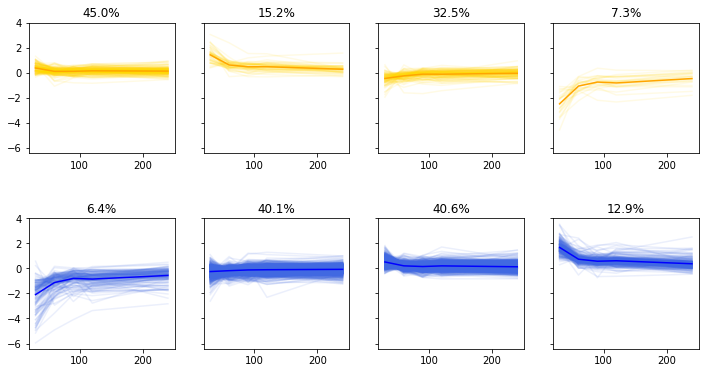

In [5]:
#define the number of clusters
nclust = 4

#calculate separate k means clusters for the "SSU" and "other" genes
centroids_SSU,_ = kmeans(SSU_time_courses,nclust)
clusters_SSU,_ = vq(SSU_time_courses,centroids_SSU)
centroids_other,_ = kmeans(other_time_courses,nclust)
clusters_other,_ = vq(other_time_courses,centroids_other)

#plot the time courses for the individual clusters into sub-panels
plt.close()
x = [30,60,90,120,240]
f, axs = plt.subplots(2, nclust, sharey=True, figsize = (12,6))
for n in range(nclust):
    axs[0][n].plot(x,np.transpose(SSU_time_courses[clusters_SSU==n,:]), c='gold',alpha=0.1)
    axs[0][n].plot(x,np.mean(SSU_time_courses[clusters_SSU==n,:], axis=0), c='orange')
    axs[0][n].set_title(str(round(SSU_time_courses[clusters_SSU==n,:].shape[0]/SSU_time_courses.shape[0] * 100, 1)) + '%')
    axs[1][n].plot(x,np.transpose(other_time_courses[clusters_other==n,:]), c='royalblue',alpha=0.1)
    axs[1][n].plot(x,np.mean(other_time_courses[clusters_other==n,:], axis=0), c='blue')
    axs[1][n].set_title(str(round(other_time_courses[clusters_other==n,:].shape[0]/other_time_courses.shape[0] * 100, 1)) + '%')
plt.subplots_adjust(hspace = 0.5)
#plt.savefig('clustered_time_courses.svg')
plt.show()

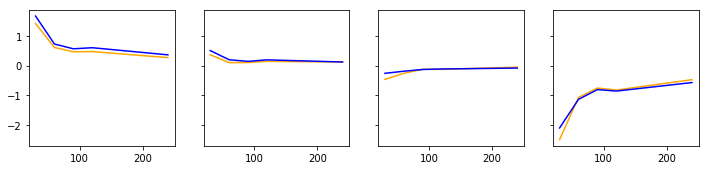

In [6]:
#compare mean behaviour for the equivalent clusters

#establish correspondence between the clusters in the figure above (established by visual inspection)
correspondence = [[1,0,2,3],[3,2,1,0]]
plt.close()
x = [30,60,90,120,240]
f, axs = plt.subplots(1, nclust, sharey=True, figsize=(12,2.5))
for n in range(nclust):
    axs[n].plot(x,np.mean(SSU_time_courses[clusters_SSU==correspondence[0][n],:], axis=0), c='orange')
    axs[n].plot(x,np.mean(other_time_courses[clusters_other==correspondence[1][n],:], axis=0), c='blue')
#plt.savefig('averaged_time_course_comparison.svg')
plt.show()
    

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [10]:
#recover the individual datapoints for all t=30 data in the different clusters
factor, t30 = [],[]
for n in range(SSU_time_courses.shape[0]):
    factor.append('SSU cluster ' + str(clusters_SSU[n]))
    t30.append(SSU_time_courses[n,0])

for n in range(other_time_courses.shape[0]):
    factor.append('other cluster ' + str(clusters_other[n]))
    t30.append(other_time_courses[n,0])

mc = MultiComparison(t30, factor)
result = mc.tukeyhsd(alpha = 0.01)
#convert the Tukey result to a dataframe and only keep the comparions of interest 
#(based on correspondence list defined above)
result_frame = pd.DataFrame(data=result._results_table.data[1:], columns=result._results_table.data[0])


In [9]:
#generate a reference list for the comparisons of interest
comparisons = []
for n in range(nclust):
    comparisons.append(['SSU cluster ' + str(correspondence[0][n]),'other cluster ' + str(correspondence[1][n])])
    
comparison_detail,comparison_result = [],[]
for m in range(len(comparisons)):
    if comparisons[m][0] in result_frame['group1'].values:
        select1 = result_frame.loc[result_frame['group1'] == comparisons[m][0]]
        select2 = select1.loc[select1['group2'] == comparisons[m][1]]
    else:
        select1 = result_frame.loc[result_frame['group2'].values == comparisons[m][0]]
        select2 = select1.loc[select1['group1'] == comparisons[m][1]]
    comparison_detail.append(comparisons[m][0] + ' vs. ' + comparisons[m][1])
    comparison_result.append(select2['reject'].values[0])
    
comparison_results = pd.DataFrame({'Groups':comparison_detail,'Reject':comparison_result})

print(comparison_results)

                              Groups  Reject
0  SSU cluster 1 vs. other cluster 3   False
1  SSU cluster 0 vs. other cluster 2   False
2  SSU cluster 2 vs. other cluster 1   False
3  SSU cluster 3 vs. other cluster 0   False
